# Feature engineering

# Imports and general info

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import psycopg2
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
db = 'codeforces'
usr = 'Joy'
con = psycopg2.connect(database = db, user = usr)
cur = con.cursor()

Print the tables currently in the database

In [3]:
cur.execute("""
SELECT
    table_schema || '.' || table_name
FROM
    information_schema.tables
WHERE
    table_type = 'BASE TABLE'
AND
    table_schema NOT IN ('pg_catalog', 'information_schema');
    """)
rows = cur.fetchall()
for r in rows:
    print r

('public.handles',)
('public.submissions',)
('public.tags',)
('public.contests',)
('public.hacks',)
('public.user_rating',)
('public.problem_rating',)
('public.problem_info',)


# Visualizations

## Number of people vs # of contests
count the number of people who have competed in at least $x$ contests.

This is needed to curate a good training set

In [28]:
dist = []
n_contests = range(1, 26)
for x in n_contests:
    query = """
    SELECT count(*) FROM (
        SELECT count(handle) FROM user_rating
            GROUP BY handle
            HAVING count(handle) >= %d
    ) as temp;
    """ % (x)

    con.rollback()
    cur.execute(query)
    dist.append(cur.fetchall()[0][0])

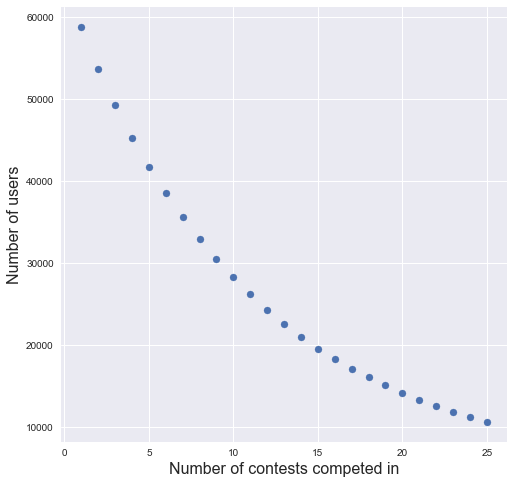

In [35]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.scatter(n_contests, dist)
plt.xlabel('Number of contests competed in', fontsize=16)
plt.ylabel('Number of users', fontsize=16)

## People tend to get better over time, but they mostly stay the same

In [64]:
pd.read_sql("""select * from user_rating limit 2;""", con)

,contestid,contestname,handle,newrating,oldrating,rank,ratingupdatetimeseconds
0,168,Codeforces Round #114 (Div. 2),Shoutmon,1209,1255,944,1332867600
1,205,Codeforces Round #129 (Div. 2),Shoutmon,1315,1209,475,1342027800


In [133]:
query = """
SELECT handle, count(handle), max(newrating), max(newrating) - min(newrating) FROM user_rating
    GROUP BY handle HAVING count(*) >= 5
"""
df_cnt_vs_rating = pd.read_sql(query, con)

In [84]:
query = """
SELECT DISTINCT ON (handle) handle, newrating, ratingupdatetimeseconds 
    FROM user_rating
    ORDER BY handle, ratingupdatetimeseconds ASC;
"""
df_first_rating = pd.read_sql(query, con)

In [85]:
query = """
SELECT DISTINCT ON (handle) handle, newrating, ratingupdatetimeseconds 
    FROM user_rating
    ORDER BY handle, ratingupdatetimeseconds DESC;
"""
df_last_rating = pd.read_sql(query, con)

In [135]:
df_last_rating.set_index('handle', inplace=True)
df_first_rating.set_index('handle', inplace=True)
df_cnt_vs_rating.set_index('handle', inplace=True)

In [136]:
df_last_rating.columns = ['lastrating', 'timelast']
df_first_rating.columns = ['firstrating', 'timefirst']
df_cnt_vs_rating.columns = ['ncontests', 'maxrating', 'change']

In [137]:
df_cnt_vs_rating = df_cnt_vs_rating.join(df_last_rating).join(df_first_rating)

In [138]:
df_cnt_vs_rating.head()

,ncontests,maxrating,change,lastrating,timelast,firstrating,timefirst
handle,,,,,,,
-----,10,1490,360,1490,1365355800,1370,1292608800
---Grigor---,96,2162,816,2068,1481042100,1492,1269108000
---JamesBond---,9,1520,166,1354,1490288700,1469,1486049700
--1,9,1560,216,1522,1496333700,1398,1451498700
--ARYA--,15,1711,243,1653,1365355800,1555,1352655000


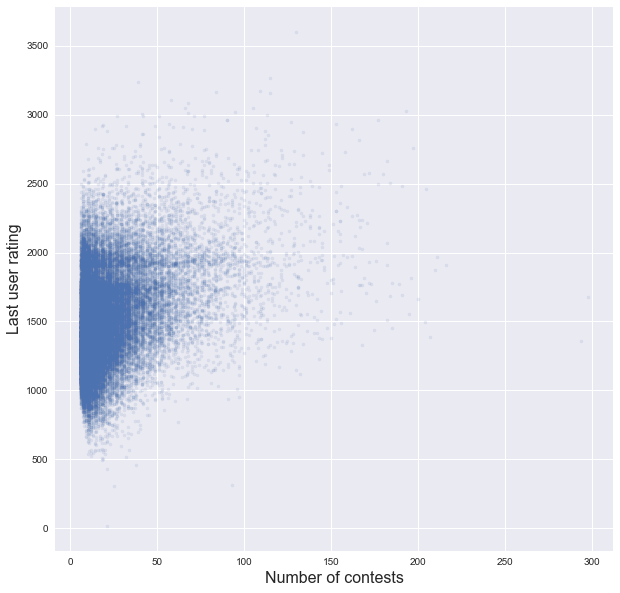

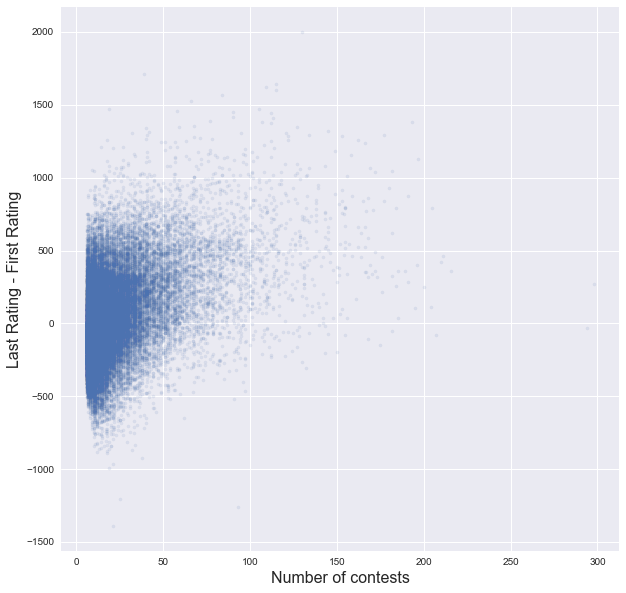

In [139]:
plt.figure()
plt.scatter(df_cnt_vs_rating['ncontests'], df_cnt_vs_rating['lastrating'], alpha=.1, s=10)
plt.xlabel('Number of contests', fontsize = 16)
plt.ylabel('Last user rating', fontsize = 16)

plt.figure()
plt.scatter(df_cnt_vs_rating['ncontests'], df_cnt_vs_rating['lastrating'] - df_cnt_vs_rating['firstrating'], alpha=.1, s=10)
plt.xlabel('Number of contests', fontsize = 16)
plt.ylabel('Last Rating - First Rating', fontsize = 16)

People who stay tend to improve over time/ people who don't improve drop out

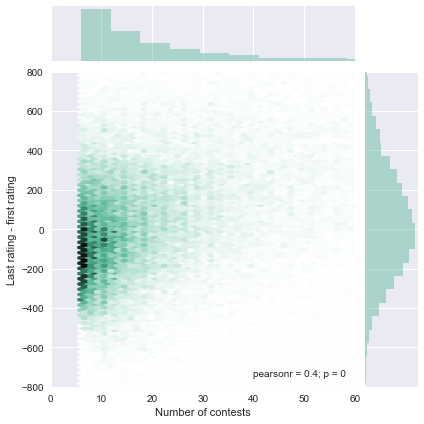

In [148]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
sns.jointplot(df_cnt_vs_rating['ncontests'], df_cnt_vs_rating['lastrating'] - df_cnt_vs_rating['firstrating'],
              kind='hex',
              color="#4cb391",
              xlim = [0, 60],
              ylim = [-800, 800]
             ).set_axis_labels('Number of contests', 'Last rating - first rating')
#plt.xlabel('Number of contests', fontsize = 16)
#plt.ylabel('Last Rating - First Rating', fontsize = 16)

##  User exodus
* Bottom line: http://codeforces.com/blog/entry/44214, bug fix caused many people's ratings to drop drastically?
* top line: 
    * http://codeforces.com/blog/entry/20762 code, 19 months ago
    * http://codeforces.com/blog/entry/20638 announcement

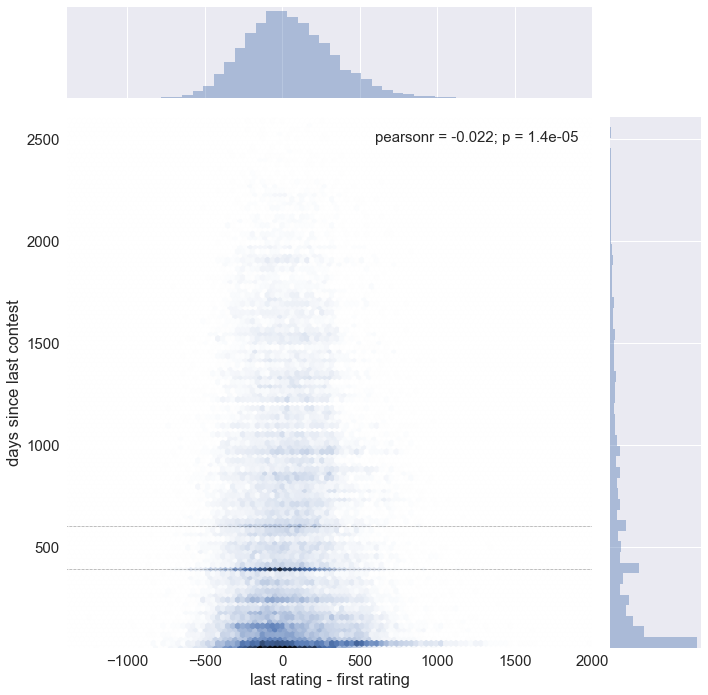

In [202]:
import time
curtime = time.time()
days = (curtime - df_cnt_vs_rating.timelast)/3600/24
g = sns.jointplot(df_cnt_vs_rating.lastrating - df_cnt_vs_rating.firstrating, days,
             size=10, kind='hex').set_axis_labels('last rating - first rating', 'days since last contest')

x0, x1 = g.ax_joint.get_xlim()
y1 = 30*13
y2 = 30*20
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": .5})
g.ax_joint.plot([x0, x1], [y1, y1], ':k') 
g.ax_joint.plot([x0, x1], [y2, y2], ':k') 


# Features
* X total number of problems solved
* X mean, variance wrong tries on a problem
* X mean, variance of difference between rating and problem rating
* X mean, variance fo amt time between solves
* X \# problems solved $\geq$ some threshold
* X current rating
* X Number in contest
* **tags??**
* **hacks?**

In [4]:
q = """ SELECT * FROM problem_rating """
problem_ratings = pd.read_sql(q, con)
valid_contests = set(problem_ratings.contestid)

problem_ratings.set_index(['contestid', 'problemid'], inplace=True)

In [5]:
cur.execute("""SELECT handle FROM handles;""")
handles = [x[0] for x in cur.fetchall()]

In [31]:
def get_problemstats(df, usr_rating):
    g = df.groupby(('contestid', 'problemid'))
    nsolved = 0
    wrong = []
    ratings = []
    solvetime = []
    n_prac = 0
    n_cont = 0
    
    # if we can't estimate ratings for a problem, for now just ignore them
    # (or--assume it's the same as the median of other problems that were done during this period??)
    for k, v in g:
        n_cont += 'CONTESTANT' in v.participanttype.values
        nsolved += 'OK' in v.verdict.values
        temp = list(v.verdict.values)
        wrong.append(len(v.verdict) - temp.count('OK'))
        
        try:
            solvetime.append(min(v.loc[v.verdict == 'OK', 'starttimeseconds']))
        except:
            pass
        
        try:
            ratings.append(problem_ratings.loc[k, 'problemrating'])
        except:
            pass
    solvetime.sort()
    timebetween = np.diff(solvetime)
    harder = sum(ratings > usr_rating)
    harder50 = sum(ratings > (usr_rating + 50))
    harder100 = sum(ratings > (usr_rating + 100))
    harder500 = sum(ratings > (usr_rating + 500))
    rating_diff = ratings - usr_rating
    
    return {'problems_solved': nsolved, # total number of problems solved
            'n_wrong_mean': np.mean(wrong),
            'n_wrong_std': np.std(wrong), # mean var of number of wrong tries on problem
            'rating_diff_mean': np.mean(rating_diff),
            'rating_diff_std': np.std(rating_diff), # mean, var of difference between user rating and problem rating
            'time_between_mean': np.mean(timebetween),
            'time_between_std': np.std(timebetween),
            'n_harder': harder, # number of harder problems than user rating
            'n_harder50': harder50,
            'n_harder100': harder100,
            'n_harder500': harder500,
            'n_contest': n_cont,
            'user_rating': usr_rating
           }

In [44]:
def get_training_data(submissions, user_rating, max_time_elapsed):
    data = []
    contest_starts = []
    g_contest = submissions.loc[submissions.participanttype == "CONTESTANT"].groupby('contestid')
    
    # for each contest
    for k, v in g_contest:
        contest_start_time = min(v.starttimeseconds)
        contestid = v.contestid.values[0]

        if contestid in valid_contests:
            contest_starts.append( [contestid, contest_start_time] )
            
#    cnt = 0
    for cid, ctime in contest_starts:
        #print "contest: ", cid
        try:
            usr_rating_old = user_rating.loc[int(cid), 'oldrating']
            usr_rating_new = user_rating.loc[int(cid), 'newrating']
            df_train = submissions.loc[np.logical_and(submissions['starttimeseconds'] < ctime, submissions['starttimeseconds'] >= (ctime - max_time_elapsed) ) ]

            x = get_problemstats(df_train, usr_rating_old)
            x['rating_change'] = usr_rating_new - usr_rating_old

            data.append(x)
        except:
            pass

#        cnt += 1
#        if cnt > 5:
    
    return data

In [1]:
from os.path import exists

# params
filename = 'training_linear_regression.csv'
maxtime = 30 * 24 * 3600 # number of seconds in a month
lastidx = 12141

for i, h in enumerate(handles[lastidx:]):
    print lastidx+i, h, "---------------------------------------"
    df_usrsub = pd.read_sql(""" SELECT * FROM submissions WHERE handle = '%s'; """ % h, con)

    df_usrrate = pd.read_sql(""" SELECT * FROM user_rating WHERE handle = '%s'; """ % h, con)
    df_usrrate.set_index('contestid', inplace=True)
    
    data = get_training_data(df_usrsub, df_usrrate, maxtime)
    data = pd.DataFrame.from_dict(data)
    data['handle'] = h
    if exists(filename):
        data.to_csv(filename, mode='a', header=False, index=False)
    else:
        data.to_csv(filename, mode='a', header=True, index=False)
#    break

In [39]:
pd.read_csv('training_linear_regression.csv')

,n_contest,n_harder,n_harder100,n_harder50,n_harder500,n_wrong_mean,n_wrong_std,problems_solved,rating_change,rating_diff_mean,rating_diff_std,time_between_mean,time_between_std,user_rating,handle
0,7,1,1,1,0,1.125000,1.964529,7,114,-136.250000,259.230954,605001.500000,938763.925265,1764,tourist
1,7,1,1,1,0,1.125000,1.964529,7,114,-136.250000,259.230954,605001.500000,938763.925265,1764,tourist
2,195,9,7,8,2,0.724138,2.122541,193,-1,-698.840278,607.324685,227261.744792,615138.679555,2610,tourist
3,200,9,7,8,2,0.711538,2.099327,198,-5,-694.268456,601.657159,229858.101523,616382.503469,2609,tourist
4,203,11,7,9,2,0.699074,2.069890,205,9,-694.668790,595.313602,228675.612745,608645.133324,2604,tourist
5,207,10,7,9,2,0.690909,2.052694,209,-12,-702.875776,592.582167,225958.750000,603427.084699,2613,tourist
6,212,12,8,10,2,0.684444,2.033711,213,-52,-688.704819,593.067686,224142.028302,598636.575519,2601,tourist
7,216,14,10,13,2,0.694323,2.037426,217,11,-636.117647,588.383357,222041.467593,593748.823894,2549,tourist
8,221,16,12,13,2,0.747863,2.172206,222,35,-634.748571,588.260015,218967.058824,587866.545640,2560,tourist
9,226,16,11,13,2,0.740586,2.151108,227,17,-665.550000,586.824053,216757.716814,582562.845760,2595,tourist


In [28]:
data

,n_contest,n_harder,n_harder100,n_harder50,n_harder500,n_practice,n_wrong_mean,n_wrong_std,problems_solved,rating_change,rating_diff_mean,rating_diff_std,time_between_mean,time_between_std,user_rating,handle
0,0,1,1,1,0,0,1.125,1.964529,7,114,-136.25,259.230954,605001.5,938763.925265,1764,tourist


In [321]:
problem_ratings.head()

,,problemrating
contestid,problemid,
413,B,0
324,A1,0
48,A,499
467,A,648
581,A,662
